## Set Up

In [1]:
# load libraries
import numpy as np
import pandas as pd
import seaborn as sns
from scipy.stats import shapiro, pearsonr
import matplotlib.pyplot as plt
import statsmodels.api as sm
from stargazer.stargazer import Stargazer
import watermark

In [2]:
# set plotting theme
sns.set_theme(style="whitegrid", context="paper")

In [3]:
# load raw data
raw_df = pd.read_csv('../data/raw/rawdata_new.csv')
# create copy of raw data
processed_df = raw_df.copy()

## Data Prep

### Add predictors

In [4]:
# environment minded
environment_minded_cols = ['GHG_goal', 'env_goal', 'biodiv_goal']
processed_df['environment_minded'] = processed_df[environment_minded_cols].mean(axis=1)
# perceive weather changes
perceive_weather_cols = ['percep_hail', 'percep_drought', 'percep_frost', 'percep_heavyrain', 'percep_longrain', 'percep_heat']
processed_df['perceive_weather_change'] = processed_df[perceive_weather_cols].mean(axis=1)
# anticipate negative consequences
anticipate_negative_cols = ['cons_general', 'cons_farm']
processed_df['anticipate_negative_consequences'] = processed_df[anticipate_negative_cols].mean(axis=1)
# capable implement
capable_cols = ['self_reduc', 'self_act', 'self_cap', 'self_conf', 'self_not']
processed_df['capable_implement'] = processed_df[capable_cols].mean(axis=1)
# social connectedness
social_cols = ['net_name1_imp', 'net_name2_imp', 'net_name3_imp', 'net_name4_imp', 'net_name5_imp', 'net_name6_imp', 'net_name7_imp', 'net_name8_imp', 'net_name9_imp', 'net_name10_imp']
processed_df['social_connectedness'] = processed_df[social_cols].mean(axis=1)

In [5]:
# think measures effective

# create columns that include effectiveness ratings only for applicable mitigations
measure_cols = ['legum', 'conc', 'add', 'lact', 'breed', 'covman', 'comp', 'drag', 'cov', 'plough', 'solar', 'biog', 'ecodr']
for measure in measure_cols:
    measure_eff = measure + '_eff' # effective
    measure_app = measure + '_app' # applicable
    measure_eff_app = measure + '_eff_app' # effective and applicable
    processed_df[measure_app] = [np.NAN if x == 3 else 1 for x in processed_df[measure]]
    processed_df[measure_eff_app] = processed_df[measure_eff] * processed_df[measure_app]

# take average of effectiveness ratings
measures_eff_app_cols = [c + '_eff_app' for c in measure_cols]
processed_df['think_measures_effective'] = processed_df[measures_eff_app_cols].mean(axis=1)

# find record with NAN, change to NA to average rating across farms
nan_row = np.where(processed_df['think_measures_effective'].isna())[0][0]
nan_col = np.where(processed_df.columns == 'think_measures_effective')[0][0]
processed_df.iloc[nan_row, nan_col] = processed_df['think_measures_effective'].mean()

### Add outcome variable

In [6]:
# measures implemented

# calculate proportion of applicable measures implemented
implemented_cols = ['legum', 'conc', 'add', 'lact', 'breed', 'covman', 'comp', 'drag', 'cov', 'plough', 'solar', 'biog', 'ecodr']
processed_df['num_implemented'] = (processed_df[implemented_cols] == 1).sum(axis=1)
processed_df['num_applicable'] = (processed_df[implemented_cols] != 3).sum(axis=1)
processed_df['prop_implemented'] = processed_df['num_implemented'] / processed_df['num_applicable']

### Write to CSV

In [7]:
# save processed dataframe to CSV
ols_df = processed_df[['environment_minded', 'perceive_weather_change', 'anticipate_negative_consequences', 'capable_implement', 'think_measures_effective', 'social_connectedness', 'prop_implemented']]
ols_df.to_csv('../data/processed/ols_data.csv')

## Assumptions Check
I need to check four assumptions; 1-3 before fitting my model and 4 after.

1. *Is the outcome normally distributed?*
    * Hopefully yes.
    * Visual check: plot the distribution.
    * Statistical check: Use a Shapiro Wilk test. Null hypothesis is normal distribution.
2. *Are the predictors correlated?*
    * Hopefully not.
    * Visual check: plot a scatterplot matrix and a heatmap of the correlation matrix.
    * Statistical check: use Pearson's or Spearmean correlation coefficient. Use Pearson's if predictors are normal, Spearman if not.
3. *Are there linear relationships between the predictors and the outcome variable?*
    * Hopefully yes.
    * Visual check: plot each predictor against the outcome variable.
4. *Are the errors homoscedastic?*
    * Hopefully yes.
    * Visual check: plot the residuals.

### 1. Is the outcome normally distributed?

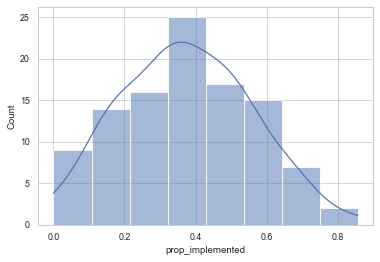

In [8]:
# visual check for normal distribution
sns.histplot(data=processed_df, x='prop_implemented', kde=True)
plt.savefig('../figures/ols_assumption_normal.png', dpi=300)

Visually, the outcome variable seems pretty normal.

In [9]:
# statistical check for normal distribution
shapiro(processed_df['prop_implemented'])

ShapiroResult(statistic=0.9865807294845581, pvalue=0.37496018409729004)

Statistically, the outcome variable seems pretty normal. The null hypothesis of the Shapiro-Wilk test is that the data was drawn from a normal distribution. A test with the p-value above the conventional significance level of 0.05 fails to reject the null hypothesis of normality.

*Conclusion:* Assumption met.

### 2. Are the predictors correlated?

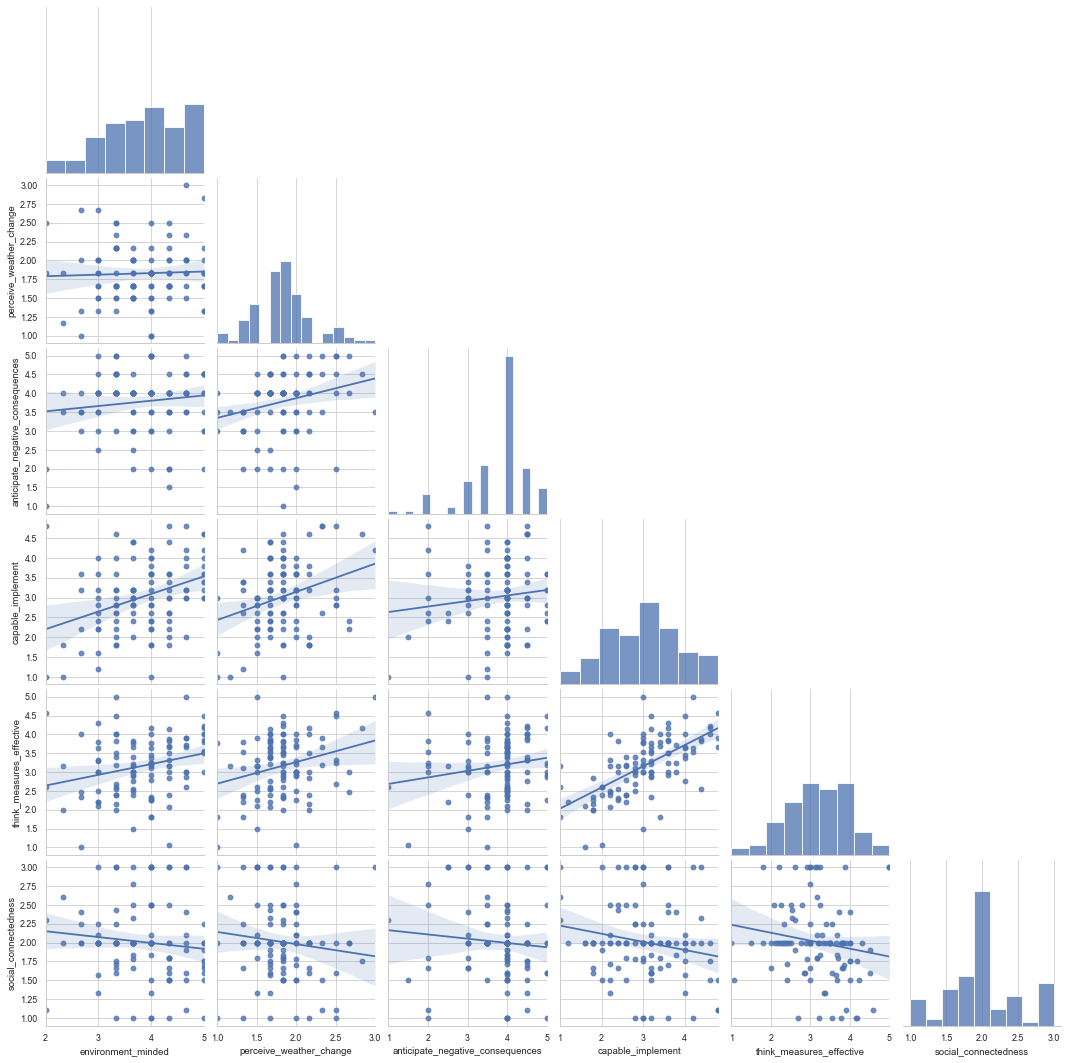

In [10]:
# visual check for correlated predictors
X = processed_df[['environment_minded', 'perceive_weather_change', 'anticipate_negative_consequences', 'capable_implement', 'think_measures_effective', 'social_connectedness']]
sns.pairplot(X, kind='reg', corner=True)

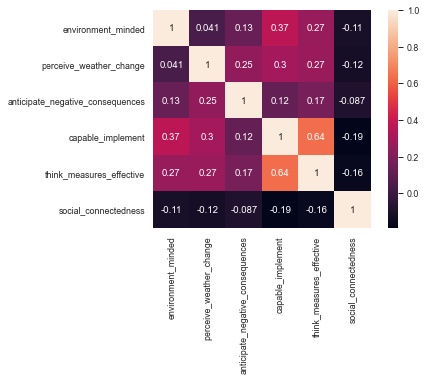

In [11]:
# another visual check for correlated predictors
sns.heatmap(X.corr(), annot=True, square=True)
plt.savefig('../figures/ols_assumption_correlated.png', dpi=300)

Visually, the correlation seems low between predictors. The highest correlated variables are `capable_implement` and `think_measures_effective` with a correlation of 0.64. I'll test the statistical significance of that correlatin now.

In [12]:
# statistical check for correlated predictors
pearsonr(processed_df['capable_implement'], processed_df['think_measures_effective'])

(0.6359896967141423, 3.105825606561878e-13)

That p-value is super low! I reject the null hypothesis that the two predictors are not correlated.

*Conclusion:* Assumption NOT met. Need to combine features `capable_implement` and `think_measures_effective`.

### 3. Are there linear relationships between the predictors and the outcome variable?

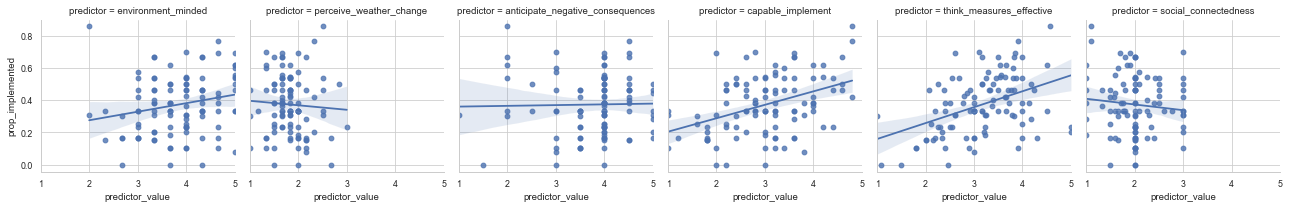

In [13]:
# visual check for linear relationships
vars_df = pd.melt(processed_df, id_vars=['prop_implemented'], value_vars=['environment_minded', 'perceive_weather_change', 'anticipate_negative_consequences', 'capable_implement', 'think_measures_effective', 'social_connectedness'], var_name='predictor', value_name='predictor_value')
g = sns.FacetGrid(vars_df, col='predictor')
g.map(sns.regplot, 'predictor_value', 'prop_implemented')
plt.savefig('../figures/ols_assumption_linear.png', dpi=300)

*Conclusion:* Assumption met.

## Model Fit

In [14]:
Y = processed_df['prop_implemented']
X = processed_df[['environment_minded', 'perceive_weather_change', 'anticipate_negative_consequences', 'capable_implement', 'think_measures_effective', 'social_connectedness']]
X = sm.add_constant(X)
model = sm.OLS(Y, X)
results = model.fit()

### 4. Are the errors homoscedastic?

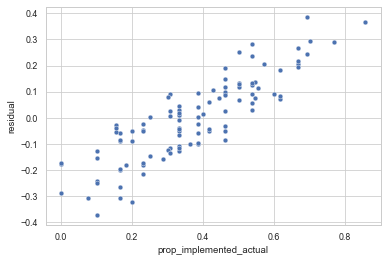

In [15]:
# visual check for homoscedastic errors
# plot residuals against outcome variable
residual_df = pd.DataFrame({'prop_implemented_actual':processed_df['prop_implemented'],
                            'residual':results.resid,
                            'prop_implemented_predicted':results.fittedvalues})
sns.scatterplot(data=residual_df, x='prop_implemented_actual', y='residual')
plt.savefig('../figures/ols_assumption_residuals.png', dpi=300)

There is a positive relationship between the residuals and the outcome variable, but the variance looks consistent across the range of actual outcome values.

*Conclusion:* Assumption met.

## Metrics and Visualizations

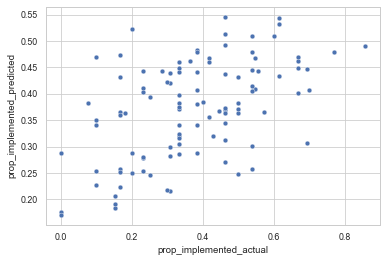

In [16]:
# visual check of model fit
sns.scatterplot(data=residual_df, x='prop_implemented_actual', y='prop_implemented_predicted')
plt.savefig('../figures/ols_actual_vs_predictions.png', dpi=300)

There seems to be a linear relationship between model predictions and actual values, but it is not a tight relationship. This suggests the model captures some of the variation in the data.

In [17]:
# view summary table
Stargazer([results])

# manually save in notebook

# Version details

In [18]:
%load_ext watermark
%watermark

Last updated: 2021-12-15T18:07:41.947026-08:00

Python implementation: CPython
Python version       : 3.7.7
IPython version      : 7.19.0

Compiler    : Clang 4.0.1 (tags/RELEASE_401/final)
OS          : Darwin
Release     : 19.6.0
Machine     : x86_64
Processor   : i386
CPU cores   : 4
Architecture: 64bit



In [19]:
%watermark -iv

statsmodels: 0.12.1
seaborn    : 0.11.1
pandas     : 1.2.0
numpy      : 1.19.2
watermark  : 2.2.0
matplotlib : 3.3.2
sys        : 3.7.7 (default, Mar 26 2020, 10:32:53) 
[Clang 4.0.1 (tags/RELEASE_401/final)]

